In [25]:
# MUST INSTALL TENSORFLOW-TEXT

!pip install tensorflow-text

In [ ]:
# GPU information - Shifted to Colab A100 for speed/efficiency

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Nov  9 08:08:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
# BERT - EMBEDDING

url = 'https://raw.githubusercontent.com/ElsieElsevier/BIAI/refs/heads/main/SPAM%20text%20message%2020170820%20-%20Data.csv'

def load_data(url):
    """Load dataset from GitHub"""
    return pd.read_csv(url)

def prepare_data(df):
    """Encode target spam/ham and split into train/val/test"""
    label_map = {'spam': 1, 'ham': 0} # BERT doesn't encode labels, need to do it manually
    labels = df['Category'].map(label_map).astype(int)

    # First split - 70:30, assigning temp to the 30%
    X_train, X_temp, y_train, y_temp = train_test_split( df['Message'].values, labels.values, test_size=0.3, random_state=42, stratify=labels)

    # Second split - Split 30% into halves, one for val and one for test
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    return X_train, X_val, X_test, y_train, y_val, y_test

class BertEmbedding: # Initialize BERT layers
    def __init__(self):
        # Grabbing preprocessor and encoder from tfhub because of ease
        self.preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
        self.encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=False) # We're not training

    def get_embeddings(self, texts, batch_size=32): # Function to actually extract embeddings in form of vectors
        """Extract embeddings"""
        embeddings = []

        # Create Tensor dataset for ingestion
        dataset = tf.data.Dataset.from_tensor_slices(texts).batch(batch_size)

        # For loop to use preprocessor for batched job
        for batch in dataset:
            preprocessed = self.preprocessor(batch)
            batch_embeddings = self.encoder(preprocessed)['pooled_output'] # Get pooled (avg) embedding
            embeddings.append(batch_embeddings.numpy()) # Save it back to our list

        # Concatenate everything together
        final_embeddings = np.vstack(embeddings) # Use numpy vstack to stack arrays aka combining the embeddings
        return final_embeddings


class DataContainer: # I want to prevent saving locally, less management of files
    """Container class to hold all embeddings and labels in runtime memory"""
    def __init__(self):
        self.train_embeddings = None
        self.test_embeddings = None
        self.train_labels = None
        self.test_labels = None


def vectors(): # Finally getting the vectors
    # Load data
    url = 'https://raw.githubusercontent.com/ElsieElsevier/BIAI/refs/heads/main/SPAM%20text%20message%2020170820%20-%20Data.csv'
    df = load_data(url)

    # Use prepare_data function for split
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df)

    # Initialize BERT embedding extractor
    bert = BertEmbedding()

    # Creating DataContainer
    data = DataContainer()

    # Extract embeddings and store in container
    data.train_embeddings = bert.get_embeddings(X_train)
    data.val_embeddings = bert.get_embeddings(X_val)  # Extract embeddings for validation set
    data.test_embeddings = bert.get_embeddings(X_test)
    data.train_labels = y_train
    data.val_labels = y_val  # Store validation labels
    data.test_labels = y_test

    return data

# Run to store the data in vector() in data_container for second neural network ingestion
data_container = vectors()

In [ ]:
"""
The embeddings are stored in the data_container object with:
- data_container.train_embeddings  # Shape: (n_train_samples, 768)
- data_container.test_embeddings   # Shape: (n_test_samples, 768)
- data_container.val_embeddings    # Shape: (n_test_samples, 768)
- data_container.train_labels      # Shape: (n_train_samples,)
- data_container.val_labels        # Shape: (n_test_samples,)
- data_container.test_labels       # Shape: (n_test_samples,)

Each embedding vector has 768 dimensions (BERT's default output size).
"""

In [48]:
# USE VECTORIZED DATA TO TRAIN MODEL AND USE VAL SET TO VALIDATE

def load_data(data_container):
    """Load and prepare data from the data container"""
    data = {'train': {
        'X': data_container.train_embeddings, 'y': data_container.train_labels},
        'val': {'X': data_container.val_embeddings,'y': data_container.val_labels}
            } # Assigning 'y' to both is okay because we're mapping it to X and val

    # Verify shape for debugging
    print(f"Training data shape: {data['train']['X'].shape}")
    print(f"Validation data shape: {data['val']['X'].shape}")

    return data

def create_model(input_dim, learning_rate=0.0001, dropout_rates=[0.5, 0.4]): # Adjust param here for ease of use
    """Create and compile the model"""
    model = Sequential([
        # First layer with L2 regularization
        Dense(64, activation='relu', input_shape=(input_dim,), kernel_regularizer=l2(0.01)), Dropout(dropout_rates[0]),
        # Second layer with L2 regularization
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)), Dropout(dropout_rates[1]),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
        )

    model.summary() # Verify architecture

    return model

# TRAINING MODEL AND VALIDATION

def train_model(model, data, batch_size=128, epochs=300, patience=10): # Even with 300 epoch, it doesn't reach patience = 10
    """Model training with stoppage"""
    # Patience - Early Stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min',
        restore_best_weights=True,
        min_delta=0.001, # NEED MINIMAL CHANGE OR ELSE IT'LL NEVER STOP
        verbose=1
    )

    # Shuffle training data - Decide to shuffle here instead because we only run BERT embedding extraction once
    X_train_shuffled, y_train_shuffled = shuffle(data['train']['X'], data['train']['y'], random_state=42)

    # Train model
    history = model.fit(
        X_train_shuffled,
        y_train_shuffled,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(data['val']['X'], data['val']['y']), # Make sure it's val and not test
        callbacks=[early_stopping],
        shuffle=True,
        verbose=1
    )

    return history

def plot_training_history(history):
    """Plot training and metrics"""
    plt.figure(figsize=(12, 4))

    # Epoch vs. Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    # Epoch vs. Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

Training data shape: (3900, 768)
Validation data shape: (836, 768)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                     │ (None, 64)                  │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,329 (200.50 KB)

 Trainable params: 51,329 (200.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.7987 - loss: 2.0927 - val_accuracy: 0.8660 - val_loss: 1.9273
Epoch 2/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8636 - loss: 1.9385 - val_accuracy: 0.8660 - val_loss: 1.8401
Epoch 3/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8550 - loss: 1.8767 - val_accuracy: 0.8660 - val_loss: 1.7448
Epoch 4/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8577 - loss: 1.7725 - val_accuracy: 0.8660 - val_loss: 1.6607
Epoch 5/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8618 - loss: 1.6830 - val_accuracy: 0.8660 - val_loss: 1.5828
Epoch 6/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8658 - loss: 1.6060 - val_accuracy: 0.8648 - val_loss: 1.5095
Epoch 7/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8653 - loss: 1.5392 - val_accuracy: 0.8636 - val_loss: 1.4435
Epoch 8/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8812 - loss: 1.4580 - val_accuracy: 0.8732 - 

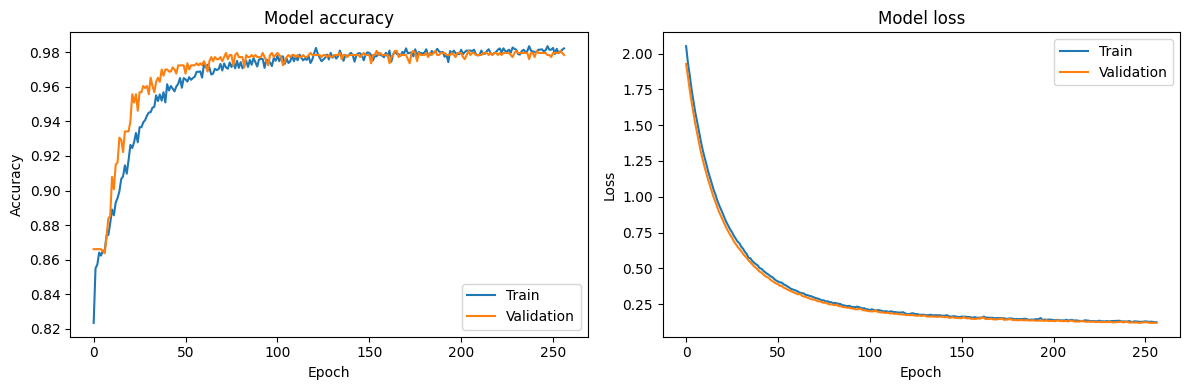

In [41]:
def training_phase():
    # Load data

    data = load_data(data_container) # Remember to use the vector data fro data_container
    if data is None: # Stop because there's no data
        return

    # Create model
    input_dim = data['train']['X'].shape[1] # Input dimension of BERT output still needs to match input
    model = create_model(input_dim)

    # Train model
    history = train_model(model, data)

    # Plot results
    plot_training_history(history)

    return model, history

# RUN IT LETS GO
model, history = training_phase()

In [49]:
def final_eval(model, data_container):
    """Evaluating model with test data"""

    # Grab test data from container and shuffle
    X_test = data_container.test_embeddings
    y_test = data_container.test_labels
    X_test, y_test = shuffle(X_test, y_test, random_state=42)

    print("="*50)
    print("MODEL EVALUATION ON TEST SET")
    print("="*50)

    # Basic model evaluation
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    # Get predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Classification Report
    print("\n" + "="*20 + " Classification Report " + "="*20)
    class_report = classification_report(y_test, y_pred,
                                      target_names=['Ham', 'Spam'],
                                      digits=4)
    print(class_report)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print confusion matrix with explanations
    print("\n" + "="*20 + " Confusion Matrix Analysis " + "="*20)
    print("\nConfusion Matrix:")
    print(f"                  Predicted Ham    Predicted Spam")
    print(f"Actual Ham     |        {conf_matrix[0][0]}           {conf_matrix[0][1]}")
    print(f"Actual Spam    |        {conf_matrix[1][0]}           {conf_matrix[1][1]}")

    print("\nDetailed Breakdown:")
    print(f"• True Negatives (Ham correctly identified): {conf_matrix[0][0]}")
    print(f"• False Positives (Ham incorrectly marked as spam): {conf_matrix[0][1]}")
    print(f"• False Negatives (Spam incorrectly marked as ham): {conf_matrix[1][0]}")
    print(f"• True Positives (Spam correctly identified): {conf_matrix[1][1]}")

    # Calculate additional metrics
    precision = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
    recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])
    f1 = 2 * (precision * recall) / (precision + recall)

    print("\n" + "="*20 + " Additional Metrics " + "="*20)
    print(f"• Precision: {precision:.4f} (Accuracy of spam predictions)")
    print(f"• Recall: {recall:.4f} (Ability to find all spam)")
    print(f"• F1 Score: {f1:.4f} (Balance between precision and recall)")

    # Calculate error rates
    total_samples = np.sum(conf_matrix)
    error_rate = (conf_matrix[0][1] + conf_matrix[1][0]) / total_samples
    spam_misclass_rate = conf_matrix[1][0] / (conf_matrix[1][0] + conf_matrix[1][1])
    ham_misclass_rate = conf_matrix[0][1] / (conf_matrix[0][0] + conf_matrix[0][1])

    print("\n" + "="*20 + " Error Analysis " + "="*20)
    print(f"• Overall Error Rate: {error_rate:.4f}")
    print(f"• Spam Misclassification Rate: {spam_misclass_rate:.4f}")
    print(f"• Ham Misclassification Rate: {ham_misclass_rate:.4f}")

    return {
        'accuracy': test_accuracy,
        'loss': test_loss,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix,
        'error_rate': error_rate
    }

# Usage in a new cell:
eval_results = final_eval(model, data_container)

# You can access individual metrics if needed:
# print(f"F1 Score: {evaluation_results['f1']}")

MODEL EVALUATION ON TEST SET
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.1429

Test Accuracy: 97.97%
Test Loss: 0.1277

==================== Classification Report ====================
              precision    recall  f1-score   support

         Ham     0.9849    0.9917    0.9883       724
        Spam     0.9439    0.9018    0.9224       112

    accuracy                         0.9797       836
   macro avg     0.9644    0.9467    0.9553       836
weighted avg     0.9794    0.9797    0.9795       836


==================== Confusion Matrix Analysis ====================

Confusion Matrix:
                  Predicted Ham    Predicted Spam
Actual Ham     |        718           6
Actual Spam    |        11           101

Detailed Breakdown:
• True Negatives (Ham correctly identified): 718
• False Positives (Ham incorrectly marked as spam): 6
• False Negatives (Spam incorrectly marked as ham): 11
• True Positives (Spam correctly identified): 101

================

FINAL MODEL EVALUATION

Test Accuracy: 97.97%
Test Loss: 0.1277

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.99       724
        Spam       0.94      0.90      0.92       112

    accuracy                           0.98       836
   macro avg       0.96      0.95      0.96       836
weighted avg       0.98      0.98      0.98       836


Confusion Matrix Analysis:
True Negatives (Ham correctly identified): 718
False Positives (Ham incorrectly marked as spam): 6
False Negatives (Spam incorrectly marked as ham): 11
True Positives (Spam correctly identified): 101

Key Metrics:
Precision (Spam prediction accuracy): 0.9439
Recall (Spam detection rate): 0.9018
F1 Score: 0.9224


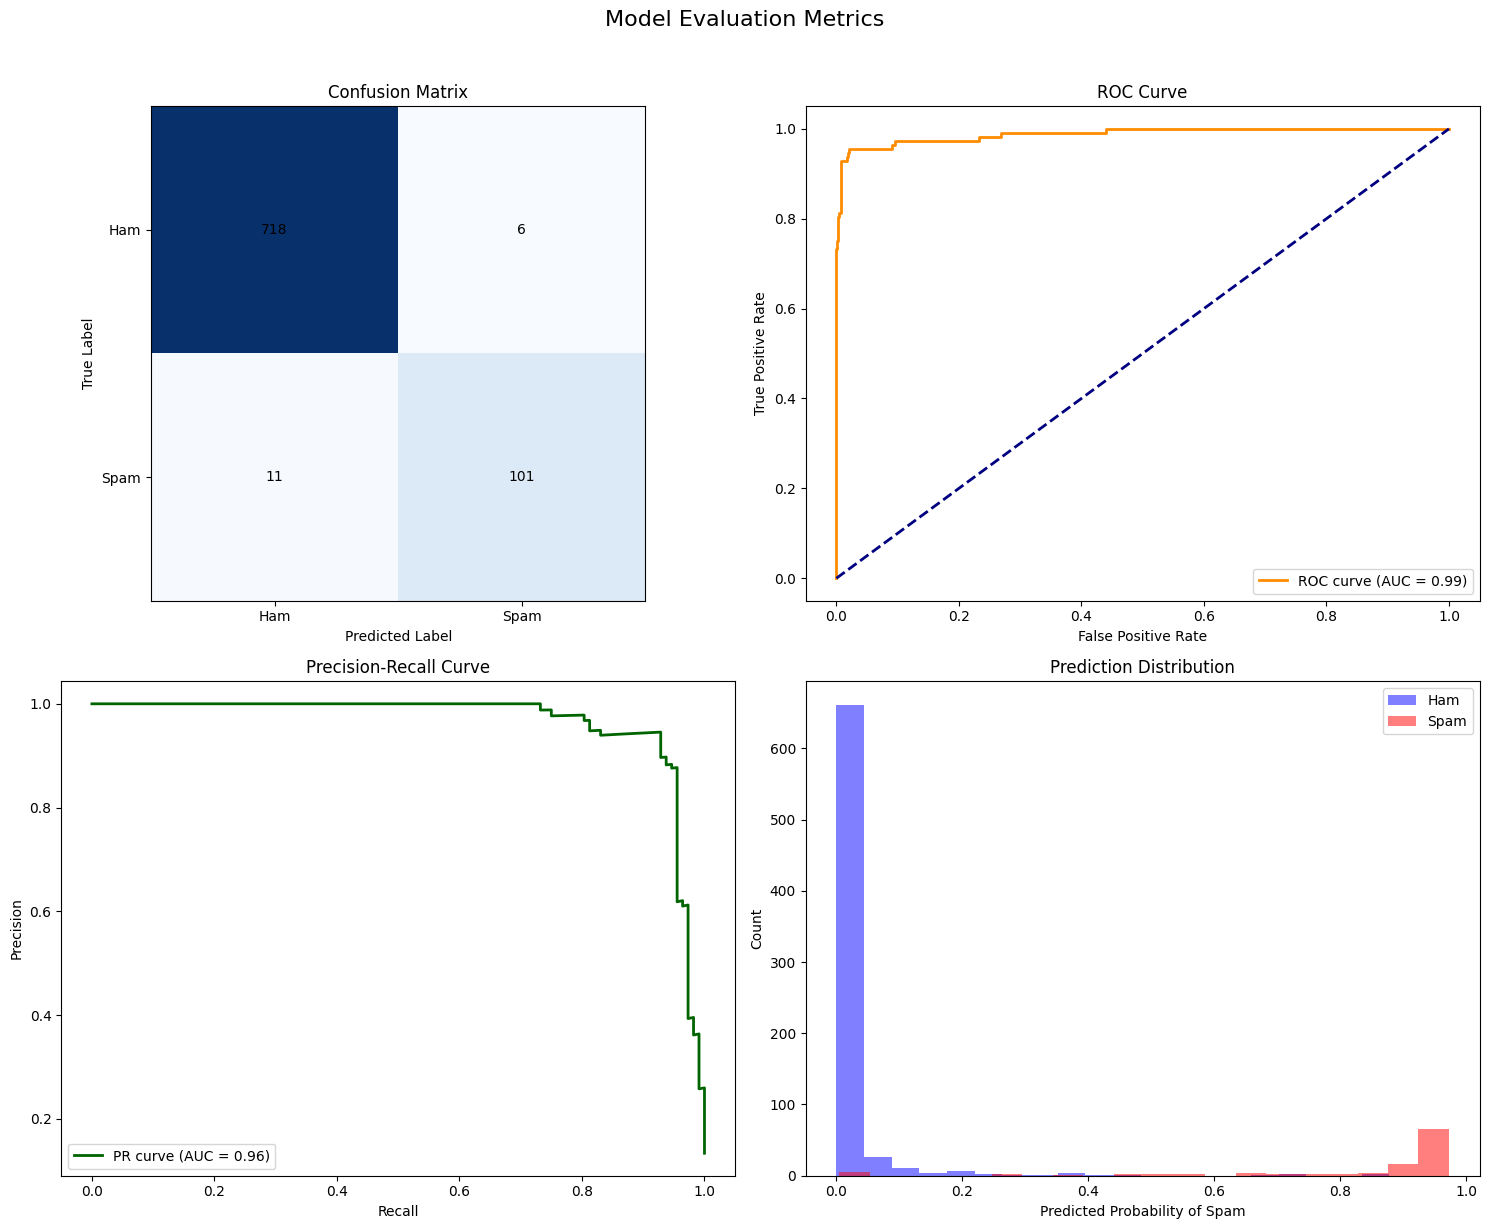

In [52]:
""" THIS IS TOO MUCH DATA AND IT'S NOT EVEN USEFUL"""

# def evaluate_final_model(model, data_container):
#     """
#     Comprehensive model evaluation with metrics and visualizations

#     Parameters:
#     model: Trained Keras model
#     data_container: Container with test data
#     """
#     from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
#     from sklearn.utils import shuffle
#     import numpy as np
#     import matplotlib.pyplot as plt

#     # Get and shuffle test data
#     X_test = data_container.test_embeddings
#     y_test = data_container.test_labels
#     X_test, y_test = shuffle(X_test, y_test, random_state=42)

#     print("="*50)
#     print("FINAL MODEL EVALUATION")
#     print("="*50)

#     # 1. Basic Evaluation
#     test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
#     print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
#     print(f"Test Loss: {test_loss:.4f}")

#     # 2. Get Predictions
#     y_pred_proba = model.predict(X_test, verbose=0)
#     y_pred = (y_pred_proba > 0.5).astype(int)

#     # 3. Classification Report
#     print("\nClassification Report:")
#     print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

#     # 4. Confusion Matrix and Metrics
#     conf_matrix = confusion_matrix(y_test, y_pred)
#     print("\nConfusion Matrix Analysis:")
#     print(f"True Negatives (Ham correctly identified): {conf_matrix[0][0]}")
#     print(f"False Positives (Ham incorrectly marked as spam): {conf_matrix[0][1]}")
#     print(f"False Negatives (Spam incorrectly marked as ham): {conf_matrix[1][0]}")
#     print(f"True Positives (Spam correctly identified): {conf_matrix[1][1]}")

#     # 5. Additional Metrics
#     precision = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
#     recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])
#     f1 = 2 * (precision * recall) / (precision + recall)

#     print("\nKey Metrics:")
#     print(f"Precision (Spam prediction accuracy): {precision:.4f}")
#     print(f"Recall (Spam detection rate): {recall:.4f}")
#     print(f"F1 Score: {f1:.4f}")

#     # 6. Visualizations
#     fig, axes = plt.subplots(2, 2, figsize=(15, 12))
#     fig.suptitle('Model Evaluation Metrics', fontsize=16, y=1.02)

#     # Confusion Matrix
#     axes[0,0].imshow(conf_matrix, cmap='Blues', interpolation='nearest')
#     axes[0,0].set_title('Confusion Matrix')
#     axes[0,0].set_xlabel('Predicted Label')
#     axes[0,0].set_ylabel('True Label')
#     # Add text annotations to confusion matrix
#     for i in range(2):
#         for j in range(2):
#             axes[0,0].text(j, i, str(conf_matrix[i, j]),
#                          ha="center", va="center")
#     axes[0,0].set_xticks([0, 1])
#     axes[0,0].set_yticks([0, 1])
#     axes[0,0].set_xticklabels(['Ham', 'Spam'])
#     axes[0,0].set_yticklabels(['Ham', 'Spam'])

#     # ROC Curve
#     fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
#     roc_auc = auc(fpr, tpr)
#     axes[0,1].plot(fpr, tpr, color='darkorange', lw=2,
#                    label=f'ROC curve (AUC = {roc_auc:.2f})')
#     axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     axes[0,1].set_title('ROC Curve')
#     axes[0,1].set_xlabel('False Positive Rate')
#     axes[0,1].set_ylabel('True Positive Rate')
#     axes[0,1].legend(loc="lower right")

#     # Precision-Recall Curve
#     precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
#     pr_auc = auc(recall_curve, precision_curve)
#     axes[1,0].plot(recall_curve, precision_curve, color='darkgreen', lw=2,
#                    label=f'PR curve (AUC = {pr_auc:.2f})')
#     axes[1,0].set_title('Precision-Recall Curve')
#     axes[1,0].set_xlabel('Recall')
#     axes[1,0].set_ylabel('Precision')
#     axes[1,0].legend(loc="lower left")

#     # Prediction Distribution
#     axes[1,1].hist(y_pred_proba[y_test == 0], bins=20, alpha=0.5,
#                    label='Ham', color='blue')
#     axes[1,1].hist(y_pred_proba[y_test == 1], bins=20, alpha=0.5,
#                    label='Spam', color='red')
#     axes[1,1].set_title('Prediction Distribution')
#     axes[1,1].set_xlabel('Predicted Probability of Spam')
#     axes[1,1].set_ylabel('Count')
#     axes[1,1].legend()

#     plt.tight_layout()
#     plt.show()

#     return {
#         'accuracy': test_accuracy,
#         'loss': test_loss,
#         'precision': precision,
#         'recall': recall,
#         'f1': f1,
#         'confusion_matrix': conf_matrix,
#         'auc_roc': roc_auc
#     }

# # Use in a new cell:
# results = evaluate_final_model(model, data_container)


Final Model Evaluation on Test Set:
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9651 - loss: 0.1697
Test accuracy: 97.01%
Test loss: 0.1492
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.98       724
        Spam       0.92      0.85      0.88       112

    accuracy                           0.97       836
   macro avg       0.95      0.92      0.93       836
weighted avg       0.97      0.97      0.97       836


Confusion Matrix:
[[716   8]
 [ 17  95]]

Confusion Matrix Explanation:
True Negatives (Ham correctly identified): 716
False Positives (Ham incorrectly marked as spam): 8
False Negatives (Spam incorrectly marked as ham): 17
True Positives (Spam correctly identified): 95

Additional Metrics:
Precision (How many identified spam were actually spam): 0.9223
Recall (How many actual spam were identified): 0.8482
F1 Score (Balance between precision and recall):